# Tutorial: creating river concentrations file for global MOM6

The purpose of this package is to create gridded files of river biogeochemical properties. Such properties are measured locally or inferred at the mouth of the river and provided in spreadsheet-style databases. To force ocean model, we need gridded files of BGC concentrations, that can be multiplied by river and coastal runoff to create the riverine flux into the ocean. DICRIVERS will find the closest gridpoint to the true river mouth geographical location, then create a "plume"
(i.e. a binary mask) on which to apply the concentration of each given river.

In [1]:
import xarray as xr
import pandas as pd
from dicrivers import make_bgc_river_input
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Open the included example dataframe of the 20 largest rivers:

In [3]:
river_df = pd.read_csv('../dicrivers/test/data/20major_rivers.csv')

In [4]:
river_df

,basinid,basinname,mouth_lon,mouth_lat,rspread,testvar
0,1,Amazon,-51.75,-1.25,5,99
1,2,Nile,31.25,31.25,5,98
2,3,Zaire,12.75,-5.75,5,97
3,4,Mississippi,-90.25,29.75,5,96
4,5,Ob,69.25,66.75,5,95
5,6,Parana,-58.75,-34.25,5,94
6,7,Yenisei,82.25,71.25,5,93
7,8,Lena,127.25,73.25,5,92
8,9,Niger,6.75,4.75,5,91
9,10,Tamanrasett,-16.25,20.25,5,90


The example dataframe contains the longitude and latitude of the river mouth, the desired radius of spreading for each river plume and values for the various biogeochemical properties. Here the radius is of 5 grid points in each direction from the river mouth. This can be adjusted on an individual basis. As a rule of thumb, the higher the horizontal resolution the larger the spreading for a plume of similar extension.

The pandas framework allows you to add variables, select and sort entries very easily. Next we need the grid onto which to generate the plumes:

In [5]:
mom6_global_grid = xr.open_dataset('../dicrivers/test/data/global_mom6_SPEAR_grid.nc')

In [6]:
mom6_global_grid

<xarray.Dataset>
Dimensions:  (xh: 360, yh: 320)
Coordinates:
  * xh       (xh) float64 -299.5 -298.5 -297.5 -296.5 ... 56.5 57.5 58.5 59.5
  * yh       (yh) float64 -77.77 -77.56 -77.34 -77.12 ... 89.26 89.48 89.69 89.9
Data variables:
    area_t   (yh, xh) float32 ...
    geolat   (yh, xh) float32 ...
    geolon   (yh, xh) float32 ...
    wet      (yh, xh) float32 ...
Attributes:
    filename:   00030101.ocean_static.nc
    title:      SPEAR_c96_o1_Control_1850_A01
    grid_type:  regular
    grid_tile:  N/A
    history:    Wed Jun  5 14:32:32 2019: ncks -F -v geolon,geolat,wet mom6_o...
    NCO:        netCDF Operators version 4.7.7 (Homepage = http://nco.sf.net,...

The xarray dataset contains the longitude, latitude of tracer points (look up Arakawa staggered grid for more details) and
a land sea mask. The land sea mask is used to constrain the various plumes not to contaminate adjacent estuaries.

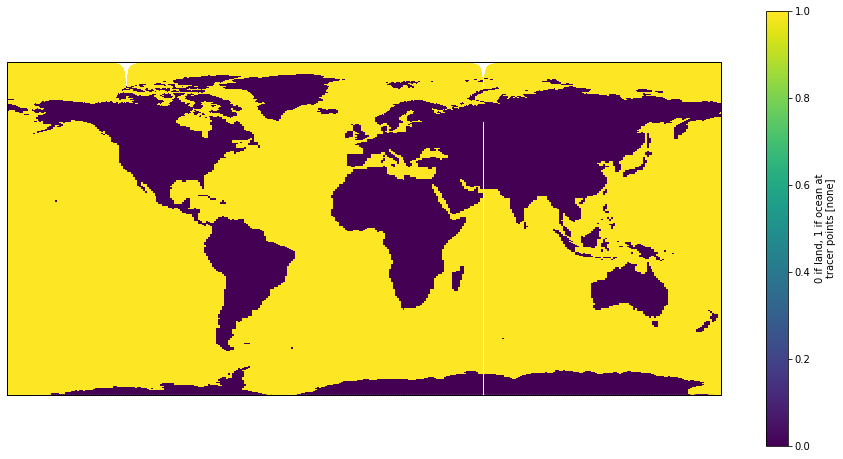

In [7]:
fig = plt.figure(figsize=[16,8])
ax = plt.axes(projection=ccrs.PlateCarree())
landseamask = mom6_global_grid['wet'].assign_coords(lon=mom6_global_grid['geolon'], 
                                                    lat=mom6_global_grid['geolat'])
landseamask.plot(ax=ax, x='lon', y='lat', 
                 transform=ccrs.PlateCarree())

To generate the concentration arrays, we use the **make_bgc_river_input** function. The arguments are the river dataframe, the list of variables we want, lon/lat/mask of the ocean grid. Optional parameters control the *method* used to merge the plumes (default='average'), the proximity range *prox* to apply (default=200 km) and the max number of iterations allowed *nitermax* for the plume spreading algo (default=1000).

In [8]:
river_conc = make_bgc_river_input(river_df, ['testvar'],
                                  mom6_global_grid['geolon'].values,
                                  mom6_global_grid['geolat'].values,
                                  mom6_global_grid['wet'].values,
                                  prox=200.)

river mouth at (lon,lat) = (-51.750000,-1.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (69.250000,66.750000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (-58.750000,-34.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (14.250000,12.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolve

The obtained xarray dataset contain the concentrations for all selected variables:

In [9]:
river_conc

<xarray.Dataset>
Dimensions:  (x: 360, y: 320)
Coordinates:
    lat      (y, x) float32 -77.7742 -77.7742 -77.7742 ... 60.27089 59.771145
    lon      (y, x) float32 -299.5 -298.5 -297.5 ... 59.99039 59.996796
Dimensions without coordinates: x, y
Data variables:
    testvar  (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

Let's make a visual check:

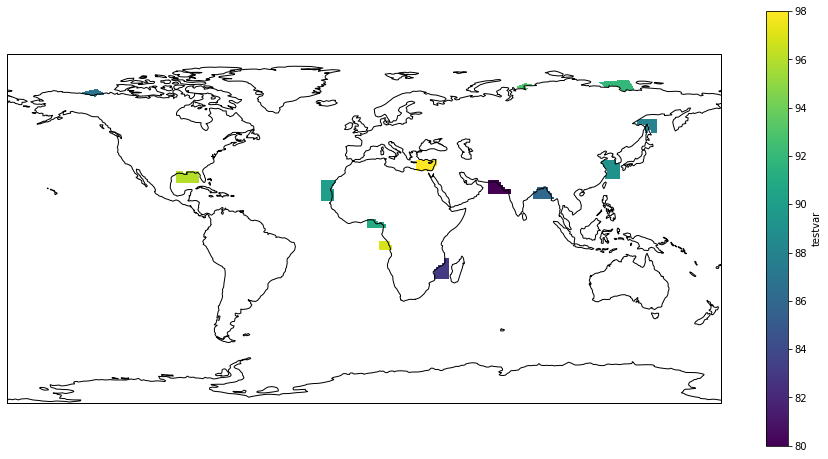

In [10]:
fig = plt.figure(figsize=[16,8])
ax = plt.axes(projection=ccrs.PlateCarree())
river_conc['testvar'].where(river_conc['testvar'] != 0).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
ax.coastlines()

Here the obvious problem is that the Amazon river is missing as it was too far from the closest ocean point.
This can be fixed by either editing the river mouth location in the dataframe or expanding the proximity range *prox* to 500 km.

In [11]:
river_conc = make_bgc_river_input(river_df, ['testvar'],
                                  mom6_global_grid['geolon'].values,
                                  mom6_global_grid['geolat'].values,
                                  mom6_global_grid['wet'].values,
                                  prox=500.)

river mouth at (lon,lat) = (14.250000,12.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (48.250000,46.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (136.750000,-28.750000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved lake or sea. If you know that river should be
there, you may need to increase the proximity range (prox)
river mouth at (lon,lat) = (86.250000,41.250000) 
is too far from the ocean and cannot not used.
It can be out of the domain (regional case) or flowing into
an unresolved

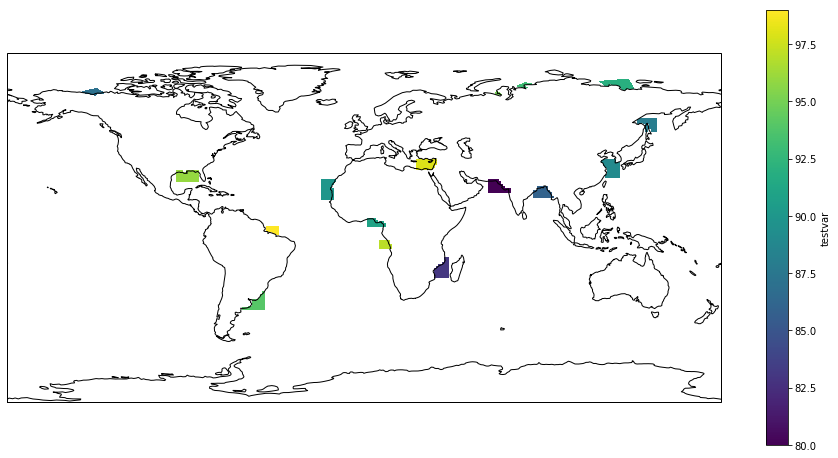

In [12]:
fig = plt.figure(figsize=[16,8])
ax = plt.axes(projection=ccrs.PlateCarree())
river_conc['testvar'].where(river_conc['testvar'] != 0).plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
ax.coastlines()

The remaining unused rivers are either flowing into unresolved sea (e.g. Volga in Caspian sea) or lakes (e.g. Chari Bousso in Lake Chad). We can finally save the end result to a netcdf file:

In [13]:
river_conc.to_netcdf('dicrivers_global.nc')